In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import transform
from scipy.io import loadmat
from scipy import signal
import numpy as np
import os

In [2]:
def get_csi(x):
    x = np.squeeze(x["csi_trace"])
    data = []
    for i in range(x.shape[0]):
        array = {}
        array["timestamp_low"] = np.squeeze(x[i][0][0][0])
        array["bfee_count"] =  np.squeeze(x[i][0][0][1])
        array["Nrx"] = np.squeeze(x[i][0][0][2])
        array["Ntx"] = np.squeeze(x[i][0][0][3])
        array["rssi_a"] = np.squeeze(x[i][0][0][4])
        array["rssi_b"] = np.squeeze(x[i][0][0][5])
        array["rssi_c"] = np.squeeze(x[i][0][0][6])
        array["noise"] = np.squeeze(x[i][0][0][7])
        array["agc"] = np.squeeze(x[i][0][0][8])
        array["perm"] = np.squeeze(x[i][0][0][9])
        array["rate"] = np.squeeze(x[i][0][0][10])
        array["csi"] = np.squeeze(x[i][0][0][11])
        
        data.append(array)
    return data

def phase_correction(ph_raw):
    m = np.arange(-28,29)
    Tp = np.unwrap(ph_raw)
    k_param = (Tp[29] - Tp[0])/(m[29] - m[0]);
    b_param = np.sum(Tp)*(1/30)

    correct_phase = []
    for i in range(30):
        correct_phase.append(Tp[i] - k_param*m[i] - b_param)
    return correct_phase

# 3 x 3 MIMO Matrix format
# [h11 h12 h13
# h21 h22 h23
# h31 h32 h33]
def apply_phcorrect(ph_raw):
    mimo_mat = np.rollaxis(ph_raw, 2, 0)
    mimo_mat = np.reshape(mimo_mat, (30, 9))

    crct_ph = []
    for col in range(9):
        crct_ph.append(phase_correction(np.array(mimo_mat)[:, col]))

    stack_crc_ph = np.vstack(crct_ph).T

    restore_ph_mat = []
    for i in range(30):
        restore_ph_mat.append(stack_crc_ph[i, :].reshape((3,3)))
    return np.array(restore_ph_mat).T

def power_delay_profile(data, keep_bins=10):
    data = np.concatenate([np.zeros_like(data[..., 0:1]), data, np.expand_dims(data[..., -1], axis=-1)], axis=-1)
    pdf = np.fft.irfft(data, axis=-1)
    pdf[..., keep_bins:] = 0
    return np.fft.fft(pdf, n=(data.shape[-1]*2)+2, axis=-1)[..., 1:data.shape[-1]-1]

def fill_gaps(csi_trace, technique):
    amp_data = []
    ph_data = []

    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]

        scaled_csi = power_delay_profile(get_scaled_csi(csi_entry))
        amp = np.absolute(scaled_csi)
        ph = np.angle(scaled_csi)

        amp_temp=[]
        ph_temp=[]

        if technique == 'fill':
            if csi_trace[ind]['Ntx'] == 1:
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())

        elif technique == 'mean':
            if csi_trace[ind]['Ntx'] == 1:
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)

                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)

                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())

    return np.hstack([amp_data, ph_data])

def dbinv(x):
    return np.power(10, (np.array(x)/10))

def get_total_rss(csi_st):
    rssi_mag = 0;
    if csi_st['rssi_a'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_a'])

    if csi_st['rssi_b'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_b'])

    if csi_st['rssi_c'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_c'])

    return 10*np.log10(rssi_mag) - 44 - csi_st['agc']

def get_scaled_csi(csi_st):
    csi = csi_st['csi']

    csi_sq = np.multiply(csi, np.conj(csi))
    csi_pwr = np.sum(csi_sq[:])
    rssi_pwr = dbinv(get_total_rss(csi_st))

    scale = rssi_pwr / (csi_pwr / 30)

    if (csi_st['noise'] == -127):
        noise_db = -92
    else:
        noise_db = csi_st['noise']

    thermal_noise_pwr = dbinv(noise_db)
    quant_error_pwr = scale * (csi_st['Nrx'] * csi_st['Ntx'])
    total_noise_pwr = thermal_noise_pwr + quant_error_pwr;

    ret = csi * np.sqrt(scale / total_noise_pwr);
    if csi_st['Ntx'] == 2:
        ret = ret * np.sqrt(2);
    elif csi_st['Ntx'] == 3:
        ret = ret * np.sqrt(dbinv(4.5));

    return ret

def read_samples(dataset_path, endswith=".csv"):
    datapaths, labels = list(), list()
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])

    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        # Add each image to the training set
        for sample in walk[2]:
            # Only keeps csv samples
            if sample.endswith(endswith):
                datapaths.append(os.path.join(c_dir, sample))
                labels.append(label)
        label += 1

    return datapaths, labels, classes

def smooth(x,window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=np.hanning(window_len)
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

def spectrogram(data, nfft=2048, window_size=1024, fs=2000, fc=10, n_components=30):
    freq_res = (fs/2)/(nfft/2)
    target_fft = int(np.ceil(150/freq_res))
    
    cmap_obj = plt.cm.ScalarMappable(cmap="jet")
    cmap_obj.set_clim(-16, 6)
        
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(data)
    
    b, a = signal.butter(8, fc/(fs/2), 'high')
    data = signal.lfilter(b, a, data, axis=0)

    for i in range(n_components):
        f,t,s = signal.spectrogram(data[:, i], 
                                   fs=fs, 
                                   window=signal.windows.gaussian(window_size, (window_size-1)/5),
                                   noverlap=window_size-1, 
                                   nfft=nfft)
        s_target=np.abs(s)[:target_fft]
        s_target /= np.sum(s_target, axis=0)
        s_target -= np.mean(s_target)
        s_target[np.where(s_target < 0)] = 0
        if (i == 0):
            s_new = s_target
        else:
            s_new += s_target

    s_new = 20*np.log10(s_new+1e-9)   
    s_new = transform.resize(s_new, (512, 512))
    s_new = np.flip(s_new, axis=0)
    return cmap_obj.to_rgba(s_new)[:, :, :3]

def compute_data(file_path, sampling, cols1, cols2):
    if (not os.path.isfile(file_path)):
        raise ValueError("File dosn't exits")

    csi_trace = get_csi(loadmat(file_path))[2000:10000]
    csi_trace = csi_trace[::sampling]
    csi_trace = fill_gaps(csi_trace, technique='mean')[:, cols1:cols2]

    return csi_trace.astype(np.float32)

In [3]:
test_data = compute_data("data/CSI_DATA_L1/kalvik/kj1.mat", 1, 0, 270)
img = spectrogram(test_data)

/home/kjakkala/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kjakkala/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


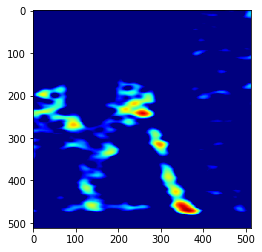

In [4]:
plt.imshow(img)

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

data = "data/CSI_50_spectrogram.h5"

hf = h5py.File(data, 'r')
X_train = np.expand_dims(hf.get('X_train'), axis=-1)
X_test = np.expand_dims(hf.get('X_test'), axis=-1)
y_train = np.eye(50)[hf.get('y_train')]
y_test = np.eye(50)[hf.get('y_test')]
classes = np.array(hf.get('labels'))
hf.close()

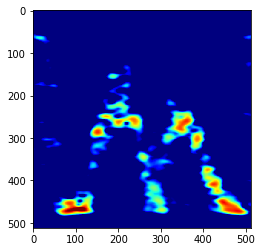

11


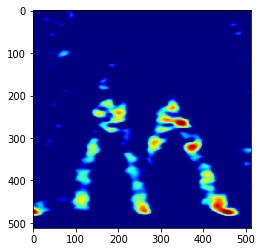

11


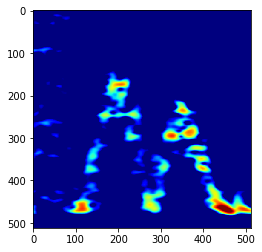

16


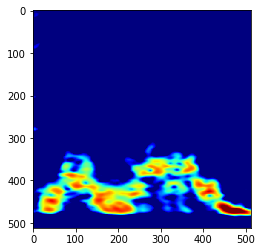

25


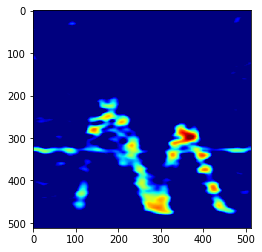

24


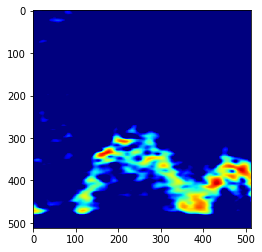

6


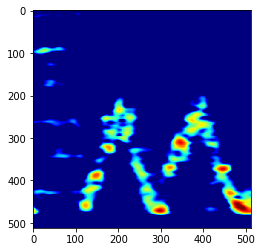

16


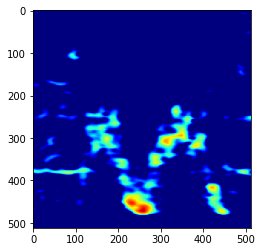

36


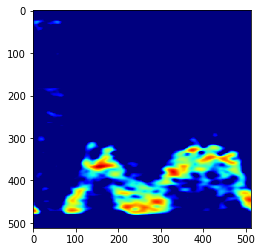

46


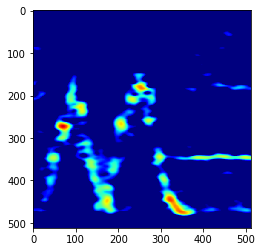

13


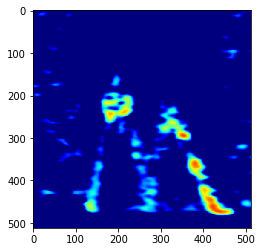

8


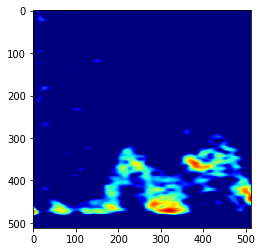

3


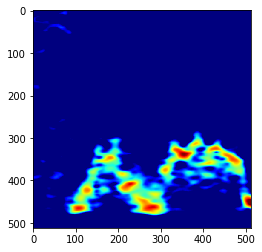

9


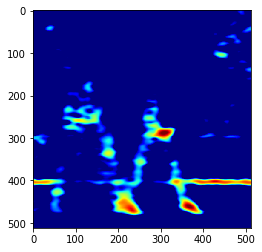

2


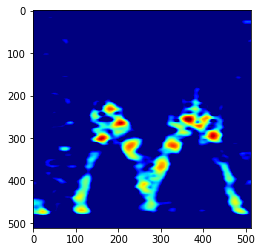

39


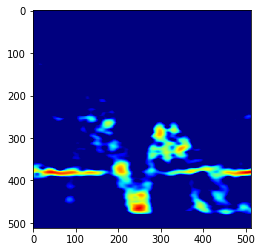

36


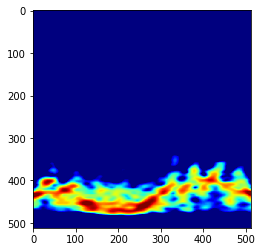

17


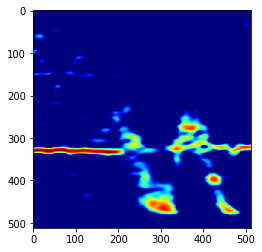

24


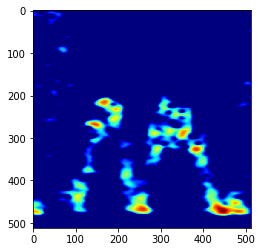

16


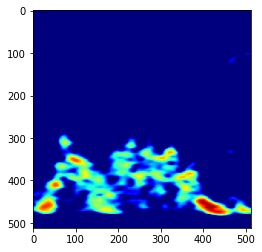

23


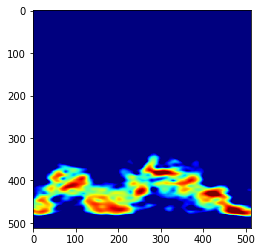

25


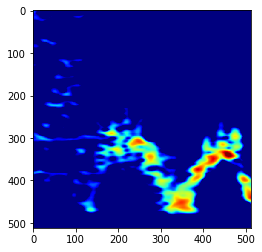

31


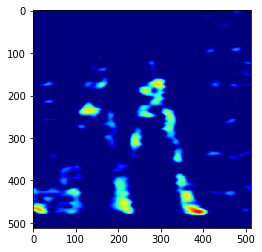

15


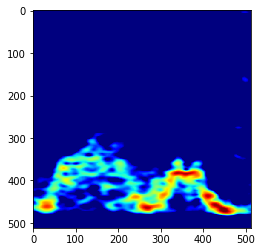

23


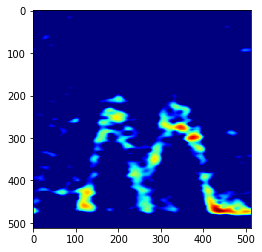

49


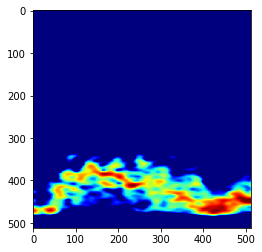

35


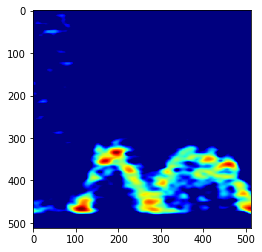

48


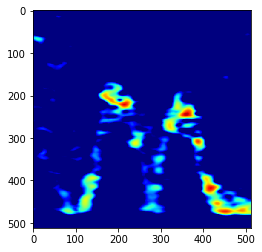

11


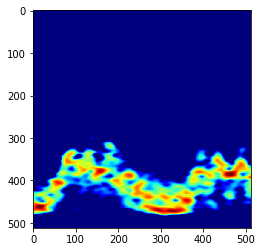

10


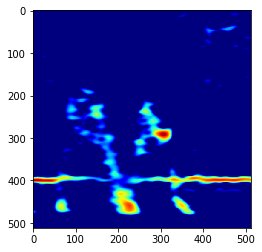

2


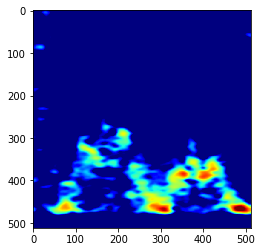

29


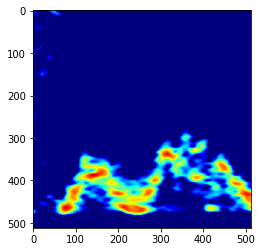

0


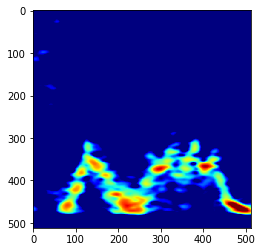

14


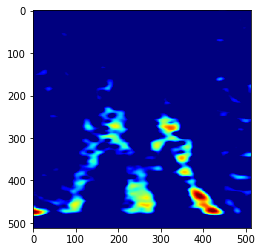

18


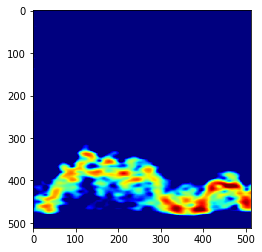

21


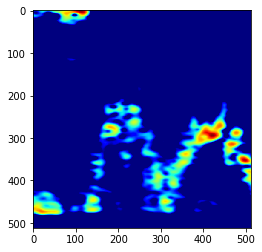

32


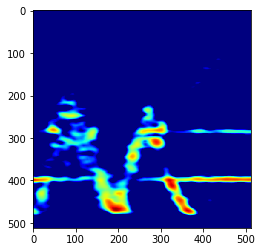

37


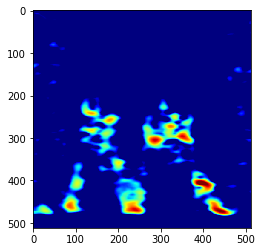

4


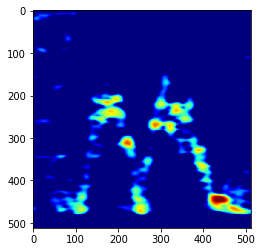

43


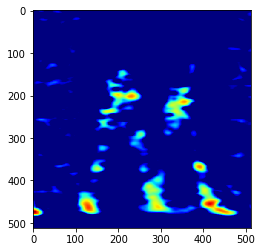

15


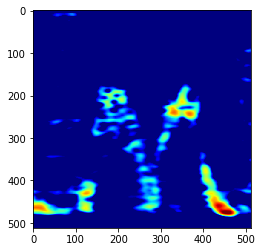

32


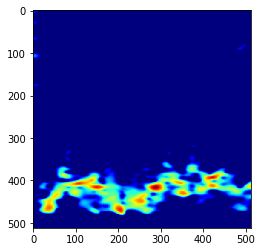

26


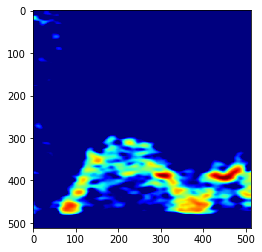

0


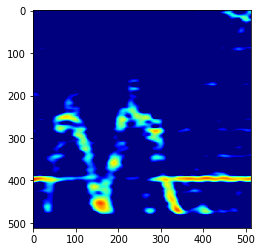

42


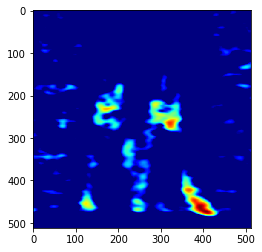

8


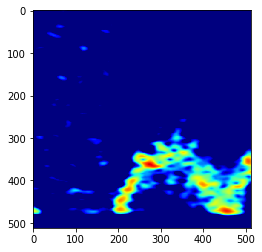

45


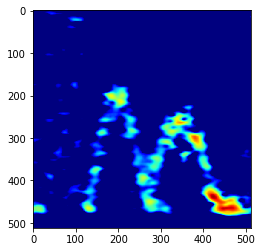

49


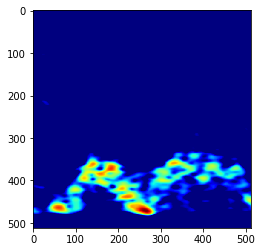

5


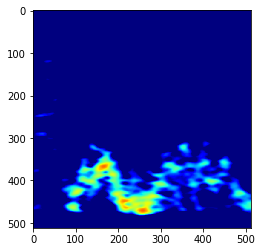

5


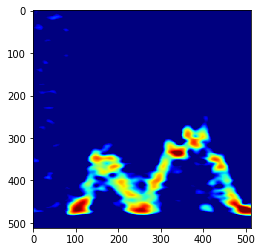

40


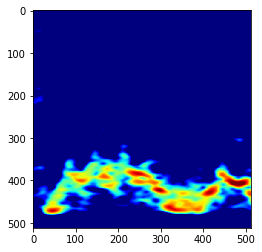

26


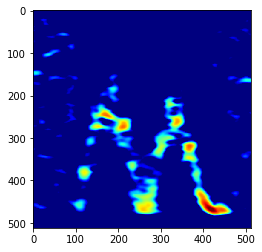

33


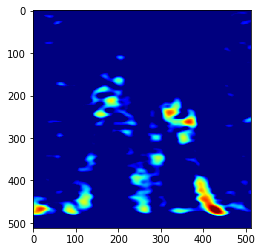

32


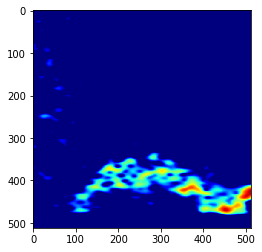

44


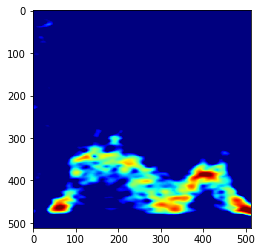

46


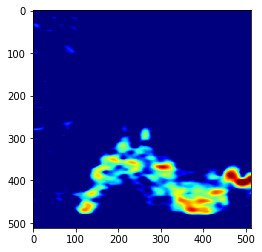

3


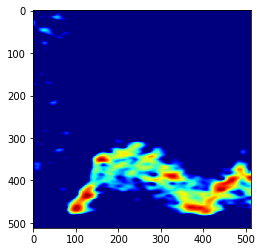

0


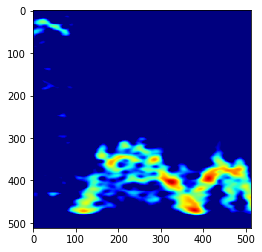

48


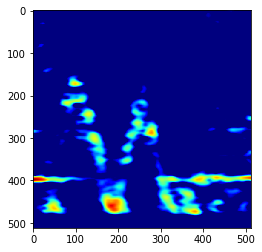

42


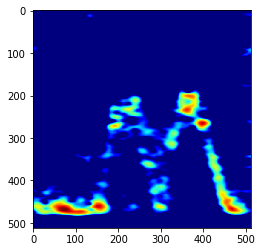

22


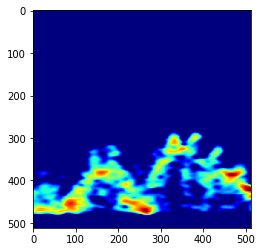

0


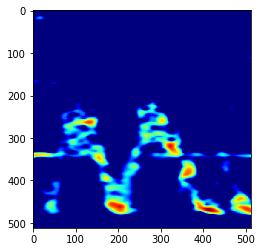

19


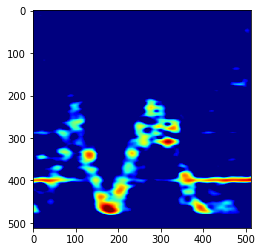

37


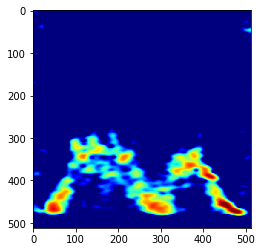

0


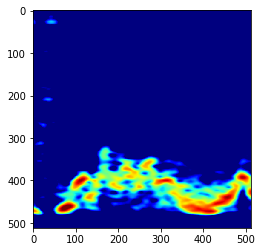

34


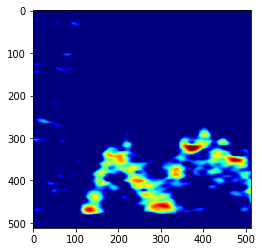

9


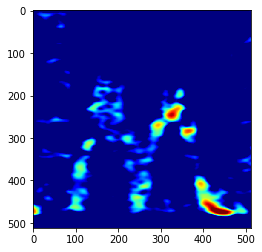

32


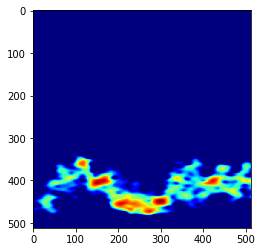

44


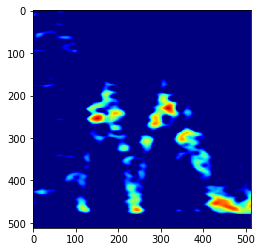

43


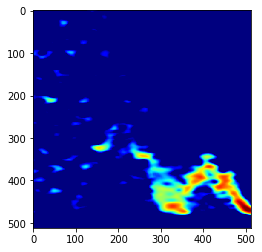

9


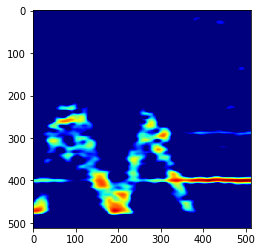

37


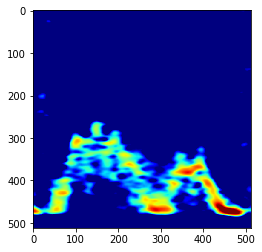

38


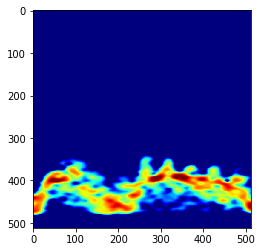

10


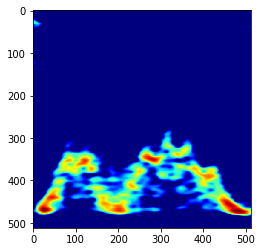

0


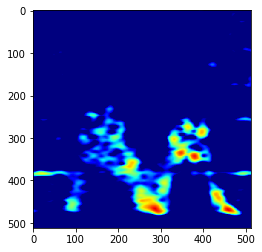

36


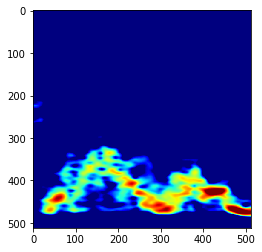

25


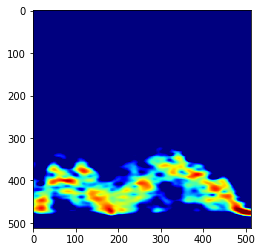

26


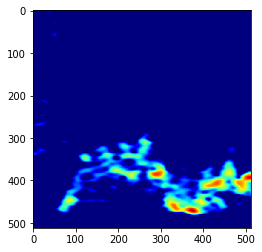

0


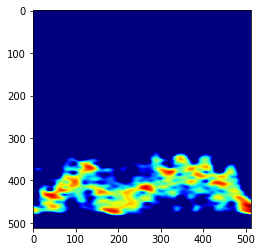

26


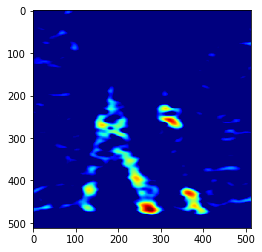

18


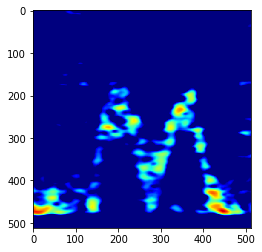

49


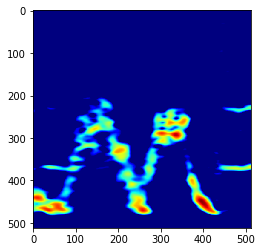

13


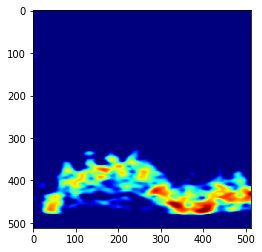

21


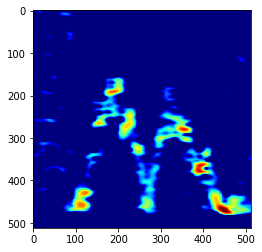

43


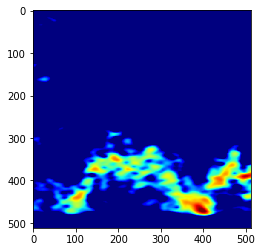

41


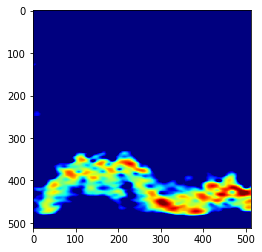

21


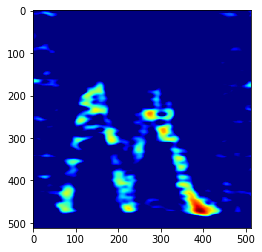

22


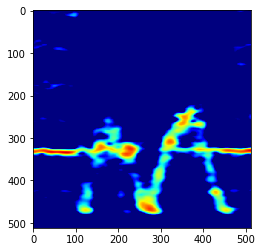

24


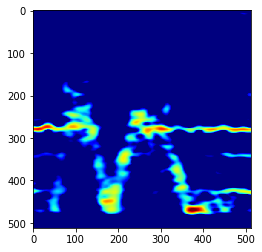

19


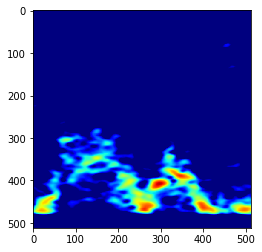

23


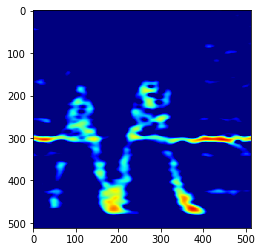

19


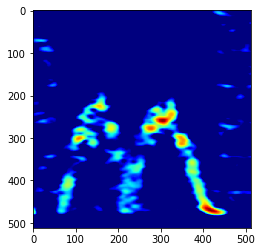

22


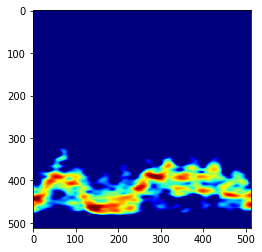

10


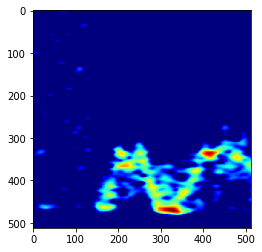

12


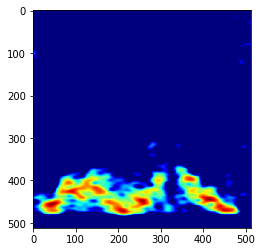

21


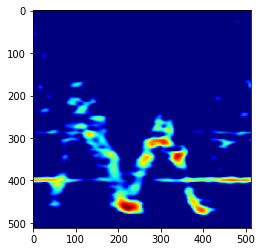

37


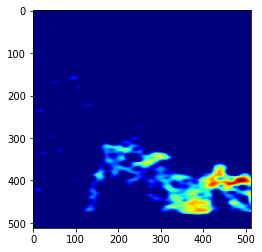

5


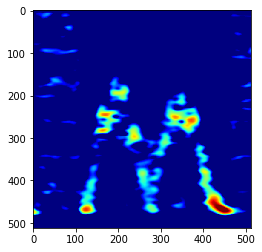

22


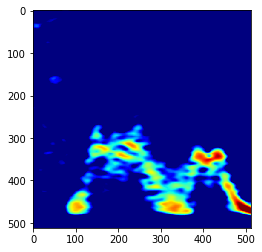

20


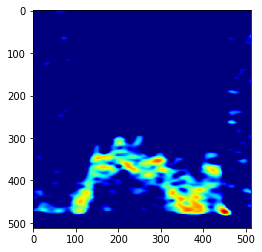

12


In [14]:
for i in range(100):
    plt.imshow(np.squeeze(X_train[i]))
    plt.show()
    print(np.argmax(y_train[i]))